# 1. IMPORTS
---

## 1.1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import scikitplot as skplt
from sklearn.utils.class_weight import compute_class_weight
import optuna
import pickle
import warnings

warnings.filterwarnings('ignore')

## 1.2. Helper functions

In [66]:
def precision_at_k(data, target, k=2000):
    """
    Calculate the precision at a specific rank k for a given dataset.

    Parameters:
    data (pd.DataFrame): A pandas DataFrame containing the data with predictions.
    target (str): The name of the column in the DataFrame that contains the true labels.
    k (int, optional): The rank at which the precision is calculated. Defaults to 2000.

    Returns:
    float: The precision at the specified rank k.
    
    Description:
    The function performs the following steps:
    1. Adds a 'ranking' column to the DataFrame, ranking the predictions in the 'predict_proba' column in descending order.
    2. Adds a 'precision_at_k' column to the DataFrame, calculating the cumulative precision at each rank.
    3. Returns the precision at the specified rank k.
    """
    data['ranking'] = data['predict_proba'].rank(ascending=False, method='first')
    data['precision_at_k'] = data[target].cumsum().div(data['ranking'])

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, target, k=2000):
    """
    Calculate the recall at a specific rank k for a given dataset.

    Parameters:
    data (pd.DataFrame): A pandas DataFrame containing the data with predictions.
    target (str): The name of the column in the DataFrame that contains the true labels.
    k (int, optional): The rank at which the recall is calculated. Defaults to 2000.

    Returns:
    float: The recall at the specified rank k.
    
    Description:
    The function performs the following steps:
    1. Adds a 'ranking' column to the DataFrame, ranking the predictions in the 'predict_proba' column in descending order.
    2. Adds a 'recall_at_k' column to the DataFrame, calculating the cumulative recall at each rank.
    3. Returns the recall at the specified rank k.

    The recall is calculated as the cumulative sum of the true positive labels up to each rank, divided by the total number of true positive labels in the dataset.
    """
    data['ranking'] = data['predict_proba'].rank(ascending=False, method='first')
    data['recall_at_k'] = data[target].cumsum().div(data['response'].sum())

    return data.loc[k, 'recall_at_k']

## 1.3. Data

In [28]:
X_test_rescaled = pd.read_csv('../data/processed/X_test_rescaled.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

df_predict = pd.read_csv('../data/processed/df_predict.csv')

## 1.4. Model

In [29]:
# load the model from disk
model = pickle.load(open('../models/best-model.pkl', 'rb'))

# 2. MODEL METRICS TRANSLATION
---

In [30]:
# Predict on test data
predict_proba = model.predict_proba(X_test_rescaled)

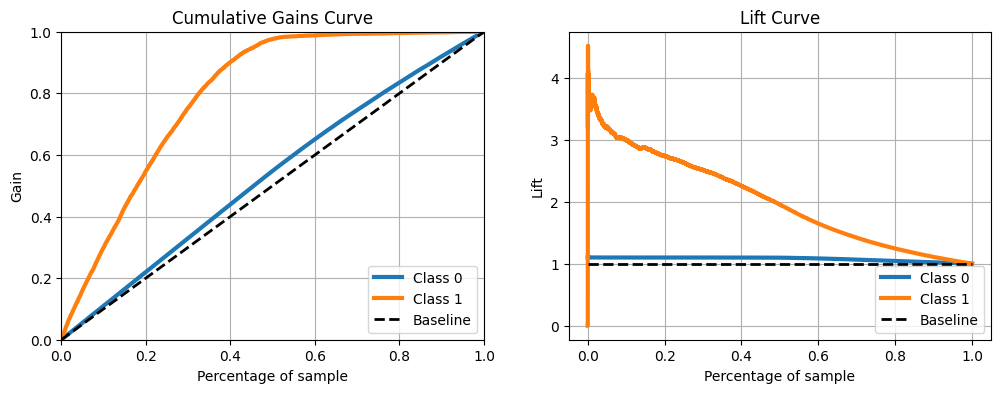

In [31]:
# Cummulative gain curve and lift curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
skplt.metrics.plot_cumulative_gain(y_test, predict_proba, ax=axes[0])
skplt.metrics.plot_lift_curve(y_test, predict_proba, ax=axes[1])
plt.show()

**CUMULATIVE GAIN CURVE TRANSLATE**
1. If we contact to **20\%** of all the sample, then we can get almost **60\%** of interest in vehicle insurance
2. If we contact to **40\%** of all the sample, then we can get almost **90\%** of interest in vehicle insurance

**LIFT CURVE TRANSLATE**
1. If we contact to **20\%** of all the sample, then we can convert almost **3 times more** than an aleatory model
2. If we contact to **40\%** of all the sample, then we can convert almost **2.5 times more** than an aleatory model

What about the first 1k more propensity customers, how many people we can achieve an interest in vehicle insurance?

In [70]:
# Precision and recall top k
precision_at_1000 = precision_at_k(df_predict, 'response', k=1000)
print(f'Precision at k: {round(precision_at_1000 * 100, 2)}%')

recall_at_1000 = recall_at_k(df_predict, 'response', k=1000)
print(f'Recall at k: {round(recall_at_1000 * 100, 2)}%')

Precision at k: 33.37%
Recall at k: 3.58%


So, if we contact to 1.000 customers, we can get **334 interested in vehicle insurance**. This number, 334, corresponds to **3.58\%** of all interested in our database.